# Modelowanie jasnosci gwiazdy za pomoca jej paraemtrów fizycznych

### Źródła danych

    NASA Exoplanet Archive : https://exoplanetarchive.ipac.caltech.edu

### Opis zmiennych w zbiorze danych

#### Zmienne objaśniajace

1. **st_teff - Temperatura efektywna gwiazdy [K]:**
   - Temperatura powierzchniowa gwiazdy, mierzona w kelwinach (K).
   - Określa, jak gorąca jest gwiazda.

2. **st_rad - Promień gwiazdy [Promień Słońca]:**
   - Najkrótsza odległość od środka gwiazdy do jej powierzchni.
   - Wyrażona w jednostkach promienia Słońca, gdzie:
   -Promień Słońca = 695 700 km.

3. **st_mass - Masa gwiazdy [Masa Słońca]:**
   - Masa badanej gwiazdy, wyrażona w jednostkach masy Słońca, gdzie:
   -Masa Słońca = 1.9891 * 10^30 kg 

4. **st_met - Metaliczność gwiazdy [dex]:**
   - Miara zawartości cięższych pierwiastków (tzw. metali) w gwieździe.
   - Wyrażona w jednostkach logarytmicznych (dex), gdzie większa wartość oznacza wyższy poziom metali.

5. **st_logg - Grawitacja powierzchniowa gwiazdy [log10(cm/s²)]:**
   - Logarytm dziesiętny przyspieszenia grawitacyjnego na powierzchni gwiazdy.
   - Wartość ta jest kluczowa w charakterystyce fizycznej gwiazd.

6. **st_lum - Jasność gwiazdy [log(Słońce)]:**
   - Logarytm jasności gwiazdy wyrażonej w jednostkach jasności Słońca.
   - Określa ilość energii emitowanej przez gwiazdę w jednostce czasu w odniesieniu do jasności Słońca.

7. **st_age - Wiek gwiazdy [Gyr]:**
   - Wiek gwiazdy wyrażony w gigalatch (Gyr).
   - Gyr = 10^9 lat ziemskich.
   - Informuje o etapie ewolucji gwiazdy.

#### Zmienna objaśniana

1. **sy_vmag - Magnitudo w systemie V (Johnson):**
   - Jasność gwiazdy mierzona w systemie fotometrycznym Johnsona.
   - Magnitudo to logarytmiczna miara jasności, gdzie mniejsze wartości oznaczają jaśniejsze obiekty.


In [19]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

#wczytywanie i wstepne odsiewanie danych
stellar_dataset = pd.read_csv(filepath_or_buffer='Data\\STELLARHOSTS_2024_spectral.csv', sep = ',')
stellar_dataset = stellar_dataset.drop(columns=['st_spectype','st_metratio'])

stellar_dataset = stellar_dataset.dropna()

print(stellar_dataset)

       st_teff  st_rad  st_mass  st_met  st_lum  st_logg  st_age   sy_dist  \
30      5388.0    0.96     1.07    0.46  -0.155     4.51    5.24   17.9323   
72      5674.0    1.17     0.96    0.04   0.143     4.30   11.80   21.1397   
79      5781.0    1.26     1.02    0.10   0.230     4.28    8.36   21.1389   
82      4157.0   25.92     1.22   -0.01   2.254     1.70    5.13  124.9530   
97      4893.0   10.64     0.99   -0.77   1.774     2.42    6.92   95.9863   
...        ...     ...      ...     ...     ...      ...     ...       ...   
44805   4886.0   14.60     2.70    0.06   2.039     2.56    0.65   46.2107   
44839   5817.0    1.34     0.95   -0.20   0.260     4.25   10.20   17.4671   
44864   5823.0    1.35     0.97   -0.20   0.262     4.18   11.04   17.4671   
44873   6387.0    1.46     1.34    0.23   0.525     4.27    1.64   15.6521   
44952   6213.0    1.64     1.31    0.15   0.561     4.16    3.12   13.4054   

        sy_plx  sy_vmag  
30     55.7363  6.61935  
72     47.2

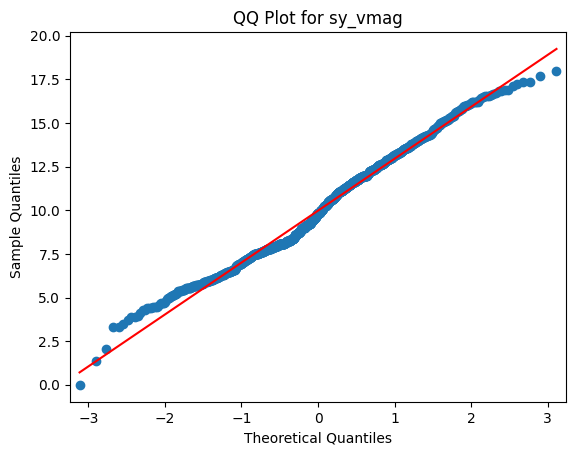

In [20]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Wykres QQ dla kolumny 'sy_vmag'
sm.qqplot(stellar_dataset['sy_vmag'], line='s')
plt.title('QQ Plot for sy_vmag')
plt.show()

histogram


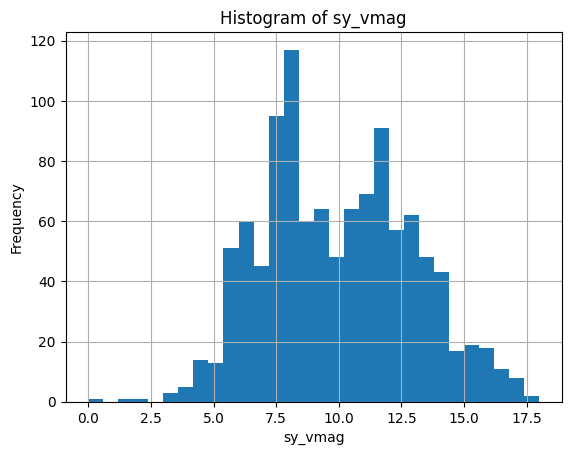

In [21]:
stellar_dataset['sy_vmag'].hist(bins=30)
plt.title('Histogram of sy_vmag')
plt.xlabel('sy_vmag')
plt.ylabel('Frequency')
plt.show()

# Dobór zmiennych

<Axes: >

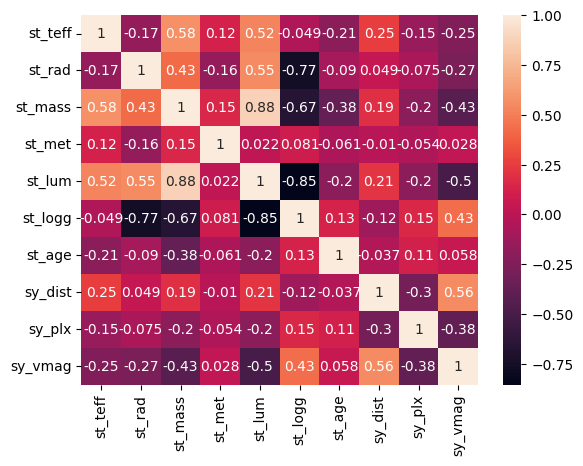

In [4]:
sns.heatmap(stellar_dataset.corr(), annot=True)

## Quasi stałe

In [5]:
# Definiujemy próg dla zmiennych quasi-stałych
threshold = 0.05 # Oznacza, że jeżeli mniej niż 5% wartości jest unikalnych, kolumna jest quasi-stała

# Znajdź kolumny, które są quasi-stałe
quasi_constant_columns = [col for col in stellar_dataset.columns if stellar_dataset[col].nunique() / len(stellar_dataset) < threshold]

# Wyświetl listę usuniętych kolumn
print("Quasi stałe:", quasi_constant_columns)

Quasi stałe: []


# Obserwacje nietypowe

1. Identyfikacja obserwacji odstających za pomocą IQR

In [6]:
def identify_outliers_iqr(dataframe, column):
    Q1 = dataframe[column].quantile(0.25)
    Q3 = dataframe[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return dataframe[(dataframe[column] < lower_bound) | (dataframe[column] > upper_bound)]

outliners = identify_outliers_iqr(stellar_dataset, 'sy_vmag')
print(outliners)

       st_teff  st_rad  st_mass  st_met  st_lum  st_logg  st_age   sy_dist  \
44608   5801.0    1.25     1.06    0.21   0.207      4.3    7.84  1.347491   

       sy_plx  sy_vmag  
44608  742.12    -0.01  


2. Identyfikacja obserwacji dźwigniowych za pomocą macierzy hat

In [7]:
import statsmodels.api as sm

def identify_leverage_points(dataframe, dependent_col):
    X = dataframe.drop(columns=[dependent_col])
    X = sm.add_constant(X)  # Dodanie stałej (intercept)
    y = dataframe[dependent_col]
    
    model = sm.OLS(y, X).fit()
    influence = model.get_influence()
    hat_matrix_diag = influence.hat_matrix_diag
    leverage_threshold = 2 * (X.shape[1] / X.shape[0])  # Próg dźwigni
    
    return dataframe[hat_matrix_diag > leverage_threshold]

levrage = identify_leverage_points(stellar_dataset, 'sy_vmag')
print(levrage)

       st_teff  st_rad  st_mass  st_met  st_lum  st_logg  st_age     sy_dist  \
82      4157.0   25.92     1.22   -0.01   2.254     1.70   5.130   124.95300   
97      4893.0   10.64     0.99   -0.77   1.774     2.42   6.920    95.98630   
120     3100.0    0.84     0.17    0.01  -1.164     4.50   0.003   128.48400   
399     4095.0   32.35     1.14   -0.71   2.700     1.89   5.200  1070.63000   
407     4649.0    8.95     1.08   -0.22   1.570     2.61   7.410   768.04500   
...        ...     ...      ...     ...     ...      ...     ...         ...   
44640   4092.1   47.20     1.70   -0.29   2.900     1.40   1.850    89.04720   
44657   4126.0   38.30     1.40   -0.27   2.730     1.50   2.950    38.77472   
44671   5146.0    0.77     0.86   -0.03  -0.456     4.61   2.600     3.20260   
44788   4538.2   11.40     1.50    0.36   1.797     2.40   3.350    32.60810   
44805   4886.0   14.60     2.70    0.06   2.039     2.56   0.650    46.21070   

           sy_plx   sy_vmag  
82       

### Wyjaśnienie funkcji `identify_leverage_points`

Funkcja identyfikuje **punkty dźwigni** w danych na podstawie modelu regresji liniowej.

#### Kroki działania funkcji:
1. **Tworzenie macierzy projektowania (`X`)**:
   - Zmienna zależna jest wyłączona, a do zmiennych niezależnych dodawany jest intercept (stała).
   - Macierz projektowania \( X \) służy do dopasowania modelu regresji.

2. **Dopasowanie modelu regresji liniowej (OLS)**:
   - Model regresji liniowej minimalizuje sumę kwadratów reszt:
     $$
     \min_{\beta} \|\mathbf{y} - \mathbf{X} \beta\|^2
     $$
   Gdzie:
   - \( \mathbf{y} \): Wektor zmiennej zależnej,
   - \( \mathbf{X} \): Macierz projektowania,
   - \( \beta \): Wektor współczynników regresji.

3. **Obliczenie macierzy wpływu (Hat Matrix)**:
   - Macierz wpływu (\( \mathbf{H} \)) obliczana jest jako:
     $$
     \mathbf{H} = \mathbf{X} (\mathbf{X}^\top \mathbf{X})^{-1} \mathbf{X}^\top
     $$
   - Elementy diagonalne \( h_{ii} \) macierzy \( \mathbf{H} \) wskazują na dźwignię każdej obserwacji. Wartości \( h_{ii} \) większe od pewnego progu wskazują na obserwacje o wysokiej dźwigni.

4. **Wyznaczenie progu dźwigni**:
   - Próg dźwigni obliczany jest jako:
     $$
     \text{Próg dźwigni} = 2 \cdot \frac{p+1}{n}
     $$
     gdzie:
     - \( p+1 \): Liczba zmiennych (łącznie z intercept),
     - \( n \): Liczba obserwacji.

5. **Selekcja punktów o wysokiej dźwigni**:
   - Funkcja zwraca obserwacje, dla których \( h_{ii} > \text{Próg dźwigni} \).

#### Znaczenie punktów dźwigni:
- Punkty dźwigni to obserwacje o nietypowych wartościach zmiennych niezależnych.
- Mają one duży wpływ na współczynniki modelu i mogą prowadzić do błędnych wniosków, jeśli są nieprawidłowe lub odstające.

#### Podsumowanie:
Funkcja identyfikuje obserwacje, które należy zbadać pod kątem ich wpływu na model. Punkty te mogą być potencjalnymi wartościami odstającymi w przestrzeni zmiennych niezależnych.



3. Identyfikacja obserwacji wpływowych za pomocą odległości Cooka

In [8]:
def identify_influential_points(dataframe, dependent_col):
    X = dataframe.drop(columns=[dependent_col])
    X = sm.add_constant(X)
    y = dataframe[dependent_col]
    
    model = sm.OLS(y, X).fit()
    influence = model.get_influence()
    cooks_d = influence.cooks_distance[0]
    cooks_threshold = 4 / len(dataframe)  # Próg dla obserwacji wpływowych
    
    return dataframe[cooks_d > cooks_threshold]

influental = identify_influential_points(stellar_dataset, 'sy_vmag')
print(influental.info())

<class 'pandas.core.frame.DataFrame'>
Index: 44 entries, 120 to 44805
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   st_teff  44 non-null     float64
 1   st_rad   44 non-null     float64
 2   st_mass  44 non-null     float64
 3   st_met   44 non-null     float64
 4   st_lum   44 non-null     float64
 5   st_logg  44 non-null     float64
 6   st_age   44 non-null     float64
 7   sy_dist  44 non-null     float64
 8   sy_plx   44 non-null     float64
 9   sy_vmag  44 non-null     float64
dtypes: float64(10)
memory usage: 3.8 KB
None


# Metoda iteracyjne doboru zmiennych

## Forward Selection (dobór w przód):

In [9]:
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split


X = stellar_dataset.drop(columns=['sy_vmag'])  # Zmienne niezależne
y = stellar_dataset['sy_vmag']  # Zmienna zależna

# Podział na dane treningowe i testowe
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def forward_selection(X, y):
    selected_features = []
    remaining_features = list(X.columns)
    best_score = 0
    
    while remaining_features:
        scores_with_candidates = []
        
        for candidate in remaining_features:
            # Dopasowanie modelu ze wszystkimi aktualnie wybranymi cechami + kandydatem
            X_selected = X[selected_features + [candidate]]
            X_selected = sm.add_constant(X_selected)  
            model = sm.OLS(y, X_selected).fit()
            score = model.rsquared_adj  # Używamy skorygowanego R² jako kryterium
            
            scores_with_candidates.append((score, candidate))
        
        # Sortowanie kandydatów według uzyskanych wyników R²
        scores_with_candidates.sort(reverse=True)
        best_new_score, best_candidate = scores_with_candidates[0]
        
        if best_new_score > best_score:
            selected_features.append(best_candidate)
            remaining_features.remove(best_candidate)
            best_score = best_new_score
            print(f"Added feature: {best_candidate}, Adjusted R²: {best_score:.4f}")
        else:
            break
    
    return selected_features


selected_features = forward_selection(X_train, y_train)
print("Selected features:", selected_features)

# Usunięcie kolumn, które nie zostały wybrane
stellar_dataset = stellar_dataset[selected_features + ['sy_vmag']]



unselected_features = list(set(X.columns) - set(selected_features))
print("Unselected features:", unselected_features)

# Usunięcie kolumn, które nie zostały wybrane
stellar_dataset = stellar_dataset[selected_features + ['sy_vmag']]


Added feature: sy_dist, Adjusted R²: 0.3090
Added feature: st_lum, Adjusted R²: 0.7297
Added feature: sy_plx, Adjusted R²: 0.8306
Added feature: st_teff, Adjusted R²: 0.8401
Added feature: st_met, Adjusted R²: 0.8424
Added feature: st_age, Adjusted R²: 0.8432
Added feature: st_rad, Adjusted R²: 0.8437
Added feature: st_logg, Adjusted R²: 0.8440
Added feature: st_mass, Adjusted R²: 0.8441
Selected features: ['sy_dist', 'st_lum', 'sy_plx', 'st_teff', 'st_met', 'st_age', 'st_rad', 'st_logg', 'st_mass']
Unselected features: []


Wszytskie zmienne wchodza do modelu

# Badanie współliniowości

1.Obliczanie wspolczynnika VIF

In [10]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
stellar_dataset = stellar_dataset.drop(columns='st_logg')

# Funkcja do obliczania VIF dla zmiennych w zbiorze danych
def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i)
                       for i in range(dataframe.shape[1])]
    return vif_data


X = stellar_dataset.drop(columns=['sy_vmag'])


X = add_constant(X)


vif_result = calculate_vif(X)



print("Wyniki analizy VIF:")
print(vif_result)



Wyniki analizy VIF:
  Variable         VIF
0    const  139.484370
1  sy_dist    1.164827
2   st_lum    6.498166
3   sy_plx    1.134625
4  st_teff    2.587880
5   st_met    1.130774
6   st_age    1.289069
7   st_rad    2.543727
8  st_mass    6.095278


Jak interpretować wyniki? 

    VIF < 5: Zmienna nie wykazuje dużej współliniowości.

    VIF od 5 do 10: Wskazuje na umiarkowaną współliniowość, warto zwrócić na to uwagę.

    VIF > 10: Wysoka współliniowość, zmienna może być problematyczna i może rozważyć się jej usunięcie lub przeprowadzenie modyfikacji.

Wniosek:

    Zadna z podanych zmiennych nie wykazuje dużej współliniowości

# Badanie istotnosci parametrów

### 1.Jakie hipotezy są weryfikowane?

Dla każdego współczynnika regresji (parametru strukturalnego) weryfikujemy następujące hipotezy:

- **Hipoteza zerowa (\(H_0\))**: Współczynnik regresji dla danej zmiennej jest równy 0 (\(\beta_i = 0\)), co oznacza, że zmienna nie ma istotnego wpływu na zmienną zależną.
- **Hipoteza alternatywna (\(H_1\))**: Współczynnik regresji dla danej zmiennej jest różny od 0 (\(\beta_i \neq 0\)), co oznacza, że zmienna ma istotny wpływ na zmienną zależną.


### 2. Jaka jest metoda weryfikacji tych hipotez?
Do weryfikacji hipotez wykorzystuje się test t-Studenta dla każdego współczynnika. Test ten oblicza wartość p-value, która pozwala określić, czy hipoteza zerowa może być odrzucona na korzyść hipotezy alternatywnej.

### Analiza istotności parametrów

In [11]:
import statsmodels.api as sm
stellar_dataset = stellar_dataset.drop(columns=['st_age','st_mass','st_rad'])

X = stellar_dataset.drop(columns=['sy_vmag'])
X = sm.add_constant(X)  
y = stellar_dataset['sy_vmag']

# Dopasowanie modelu OLS
model = sm.OLS(y, X).fit()


print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                sy_vmag   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     1094.
Date:                Thu, 21 Nov 2024   Prob (F-statistic):               0.00
Time:                        14:23:41   Log-Likelihood:                -1748.6
No. Observations:                1087   AIC:                             3509.
Df Residuals:                    1081   BIC:                             3539.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.4980      0.279     41.182      0.0

### 4. Interpretacja wyników

- **Współczynnik i p-value**: Dla każdej zmiennej w modelu regresji sprawdź p-value. Jeśli p-value jest mniejsze niż wybrany poziom istotności (zwykle 0.05), możesz odrzucić hipotezę zerową i uznać, że zmienna jest istotna dla modelu.
- **Statystyka t**: Wartość t-statystyki wskazuje, jak silny jest wpływ zmiennej na model.

#### Wnioski:
- Jeśli **p-value < 0.05**: Zmienna jest istotna i wpływa na zmienną zależną.
- Jeśli **p-value ≥ 0.05**: Zmienna nie jest istotna i jej wpływ na zmienną zależną jest znikomy.


-       w naszym modelu 3 współczynniki sa statystycznie nieistotne (st_mass,st_age,st_rad)

# Dopasowanie modelu do danych

### Interpretacja wyników

- **Odchylenie standardowe reszt (standardowy błąd estymacji modelu)**: Określa, jak duże są typowe odchylenia wartości rzeczywistych od wartości przewidywanych przez model. Mniejsza wartość oznacza lepsze dopasowanie modelu do danych.

- **Współczynnik determinacji (\( R^2 \))**: Mówi, jaka część wariancji zmiennej zależnej jest wyjaśniana przez zmienne niezależne. Im bliżej 1, tym lepsze dopasowanie modelu do danych.

- **Współczynnik korelacji wielorakiej (\( R \))**: Jest pierwiastkiem kwadratowym z \( R^2 \) i pokazuje siłę związku między zmienną zależną a wszystkimi zmiennymi niezależnymi.


In [12]:
# Odchylenie standardowe reszt
residual_std_error = np.sqrt(model.mse_resid)

# Współczynnik determinacji R^2
r_squared = model.rsquared

# Współczynnik korelacji wielorakiej R
multiple_correlation = np.sqrt(r_squared)


print("Odchylenie standardowe reszt (standardowy błąd estymacji modelu):", round(residual_std_error, 4))
print("Współczynnik determinacji (R^2):", round(r_squared, 4))
print("Współczynnik korelacji wielorakiej (R):", round(multiple_correlation, 4))


Odchylenie standardowe reszt (standardowy błąd estymacji modelu): 1.2122
Współczynnik determinacji (R^2): 0.8349
Współczynnik korelacji wielorakiej (R): 0.9137


### Wnioski

- **Odchylenie standardowe reszt (standardowy błąd estymacji modelu)**: Wynosi 1.2082. Oznacza to, że typowe odchylenie wartości rzeczywistych od wartości przewidywanych przez model jest stosunkowo niskie. Im mniejsza wartość tego wskaźnika, tym lepsze dopasowanie modelu do danych.

- **Współczynnik determinacji (\( R^2 \))**: Wynosi 0.8365, co oznacza, że około 84% wariancji zmiennej zależnej jest wyjaśniane przez zmienne niezależne w modelu. Jest to dobry wynik, który wskazuje na solidne dopasowanie modelu do danych.

- **Współczynnik korelacji wielorakiej (\( R \))**: Wynosi 0.9146, co oznacza, że istnieje silny związek między zmienną zależną a wszystkimi zmiennymi niezależnymi w modelu. Wysoka wartość \( R \) potwierdza, że zmienne niezależne dobrze przewidują zmienną zależną.


# Badanie losowości

### Test serii (Runs Test)

#### Hipotezy weryfikowane w teście serii:
1. **Hipoteza zerowa (\( H_0 \))**:
   - Reszty są losowe, czyli nie występują żadne wzorce w kolejności wartości dodatnich i ujemnych.
   - Oznacza to, że reszty są niezależne i nie są uporządkowane w sposób systematyczny.

2. **Hipoteza alternatywna (\( H_1 \))**:
   - Reszty nie są losowe, czyli występują wzorce w kolejności wartości dodatnich i ujemnych.
   - Może to oznaczać obecność autokorelacji lub innych zależności w resztach.

#### Metoda weryfikacji hipotezy:
- Obliczana jest statystyka testu serii (runs statistic), która porównuje liczbę serii reszt dodatnich i ujemnych do liczby oczekiwanej w przypadku losowego rozkładu.
- Statystyka testu oparta jest na teorii prawdopodobieństwa i rozkładzie normalnym dla dużych prób.


In [13]:
from statsmodels.sandbox.stats.runs import runstest_1samp

# Test serii dla reszt
runs_stat, p_value = runstest_1samp(model.resid)
print("Statystyka testu serii:", runs_stat)
print("p-value:", p_value)

Statystyka testu serii: -16.02811233427485
p-value: 8.131553212707186e-58


#### Wyniki testu:
- **p-value**:
  - Jeśli \( p \)-value jest mniejsze od wybranego poziomu istotności (np. \( \alpha = 0.05 \)), to odrzucamy hipotezę zerową (\( H_0 \)).
  - Wskazuje to, że reszty nie są losowe i mogą zawierać wzorce.

#### Wnioski:
- **Jeśli \( H_0 \) jest nieodrzucona**: Reszty są losowe, co sugeruje poprawny model pod kątem niezależności reszt.
- **Jeśli \( H_0 \) jest odrzucona**: Reszty nie są losowe, co może sugerować konieczność modyfikacji modelu (np. dodanie brakujących zmiennych lub przekształcenie danych).

        p < 0.05 oznacza to iż w naszym modelu reszty nie sa losowe co sugeruje konieczność modyfikacji modelu lub zmianę postaci analitycznej

# Badanie normalności

### Test Shapiro-Wilka

#### Hipotezy weryfikowane w teście Shapiro-Wilka:
1. **Hipoteza zerowa (\( H_0 \))**:
   - Reszty modelu mają rozkład normalny.
   - Rozkład reszt jest zgodny z założeniami regresji liniowej.

2. **Hipoteza alternatywna (\( H_1 \))**:
   - Reszty modelu nie mają rozkładu normalnego.
   - Rozkład reszt odbiega od normalnego, co może wskazywać na problem z modelem.

#### Metoda weryfikacji hipotezy:
- Test Shapiro-Wilka oblicza statystykę \( W \), która mierzy, na ile rozkład danych przypomina rozkład normalny.
- Im wartość \( W \) jest bliższa 1, tym bardziej dane przypominają rozkład normalny.

In [14]:

from scipy.stats import shapiro


residuals = model.resid

# Test Shapiro-Wilka dla reszt
stat, p_value = shapiro(residuals)
print("Statystyka testu Shapiro-Wilka:", stat)
print("p-value:", p_value)

alpha = 0.05
if p_value > alpha:
    print("Nie ma podstaw do odrzucenia hipotezy zerowej (rozkład reszt jest zgodny z normalnym).")
else:
    print("Odrzucamy hipotezę zerową (reszty nie mają rozkładu normalnego).")


Statystyka testu Shapiro-Wilka: 0.8996745756182717
p-value: 4.57577288059666e-26
Odrzucamy hipotezę zerową (reszty nie mają rozkładu normalnego).


#### Wyniki testu:
- **p-value**:
  - Jeśli \( p \)-value jest większe od przyjętego poziomu istotności (np. \( \alpha = 0.05 \)), nie ma podstaw do odrzucenia hipotezy zerowej (\( H_0 \)).
  - Jeśli \( p \)-value jest mniejsze od \( \alpha \), odrzucamy hipotezę zerową, co oznacza, że reszty nie mają rozkładu normalnego.

#### Wnioski:
- **Jeśli \( H_0 \) jest nieodrzucona**:
  - Rozkład reszt jest zgodny z normalnym.
  - Model spełnia jedno z podstawowych założeń regresji liniowej.
- **Jeśli \( H_0 \) jest odrzucona**:
  - Rozkład reszt odbiega od normalnego.
  - Może to wskazywać na problemy z modelem, np. brakujące zmienne, nieliniowość lub problemy z heteroskedastycznością.


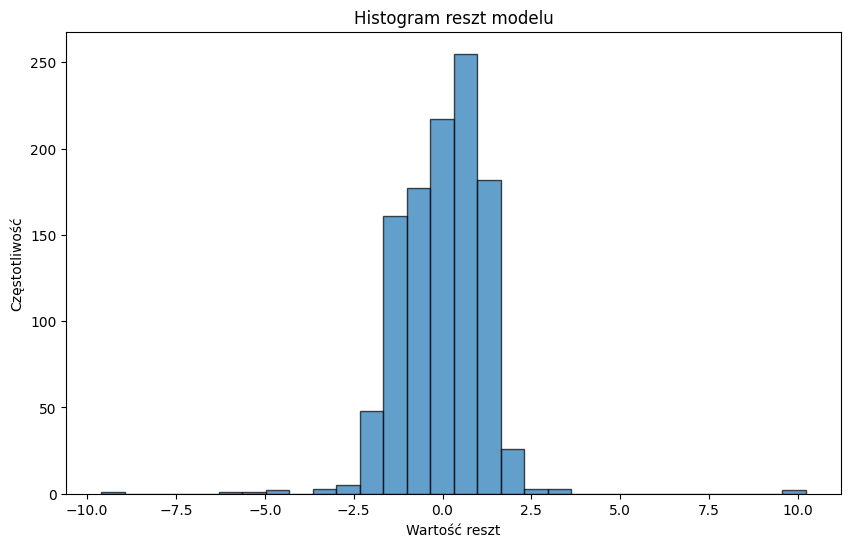

In [15]:
import matplotlib.pyplot as plt

# Tworzenie histogramu reszt
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel("Wartość reszt")
plt.ylabel("Częstotliwość")
plt.title("Histogram reszt modelu")
plt.show()


# Badanie braku autokorelacji

### z uwagi na przekrojowy charakter danych, sortowanie zostało wykonane względem zmiennej sy_dist

### Testy autokorelacji reszt: Durbin-Watson i Breuscha-Godfreya

#### Hipotezy weryfikowane w testach:

1. **Test Durbin-Watsona:**
   - **Hipoteza zerowa (\( H_0 \))**:
     - Brak autokorelacji w resztach modelu.
   - **Hipoteza alternatywna (\( H_1 \))**:
     - Istnieje autokorelacja reszt.

   **Wartość statystyki Durbin-Watsona (\( DW \)):**
   - \( DW = 2 \): Brak autokorelacji.
   - \( DW < 2 \): Dodatnia autokorelacja.
   - \( DW > 2 \): Ujemna autokorelacja.

2. **Test Breuscha-Godfreya:**
   - **Hipoteza zerowa (\( H_0 \))**:
     - Brak autokorelacji wyższych rzędów w resztach modelu.
   - **Hipoteza alternatywna (\( H_1 \))**:
     - Istnieje autokorelacja wyższych rzędów.

   **Statystyka testu Breuscha-Godfreya:**
   - Jeśli \( p\)-value jest mniejsze niż wybrany poziom istotności (np. \( \alpha = 0.05 \)), odrzucamy \( H_0 \), co wskazuje na obecność autokorelacji wyższych rzędów.


In [16]:
import pandas as pd
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_breusch_godfrey
import statsmodels.api as sm


# Sortowanie danych według kolumny `sy_dist`
stellar_dataset_sorted = stellar_dataset.sort_values(by='sy_dist')

# Definiowanie zmiennych niezależnych (X) i zależnej (y)
X = stellar_dataset_sorted.drop(columns=['sy_vmag'])
y = stellar_dataset_sorted['sy_vmag']

# Dodanie stałej do modelu
X = sm.add_constant(X)

# Dopasowanie modelu
model = sm.OLS(y, X).fit()

# Obliczenie reszt modelu
residuals = model.resid

# Test Durbin-Watsona
dw_stat = durbin_watson(residuals)
print("Statystyka testu Durbin-Watsona:", dw_stat)

# Test Breuscha-Godfreya
bg_test = acorr_breusch_godfrey(model, nlags=2)  # `nlags=2` oznacza autokorelację do 2. rzędu
print("Wynik testu Breuscha-Godfreya:")
print("Statystyka testu:", bg_test[0])
print("p-value:", bg_test[1])

# Interpretacja wyników
if dw_stat < 1.5:
    print("Sugeruje to dodatnią autokorelację reszt.")
elif dw_stat > 2.5:
    print("Sugeruje to ujemną autokorelację reszt.")
else:
    print("Brak istotnej autokorelacji reszt (wartość zbliżona do 2).")

if bg_test[1] < 0.05:
    print("Odrzucamy hipotezę zerową testu Breuscha-Godfreya. Istnieje autokorelacja wyższych rzędów.")
else:
    print("Brak podstaw do odrzucenia hipotezy zerowej testu Breuscha-Godfreya. Autokorelacja wyższych rzędów nie jest istotna.")


Statystyka testu Durbin-Watsona: 0.36744247788581413
Wynik testu Breuscha-Godfreya:
Statystyka testu: 710.3264025432018
p-value: 5.683050466180147e-155
Sugeruje to dodatnią autokorelację reszt.
Odrzucamy hipotezę zerową testu Breuscha-Godfreya. Istnieje autokorelacja wyższych rzędów.


#### Wyniki interpretacji:
1. **Test Durbin-Watsona:**
   - Jeśli statystyka \( DW \):
     - \( DW < 1.5 \): Sugeruje dodatnią autokorelację reszt.
     - \( DW > 2.5 \): Sugeruje ujemną autokorelację reszt.
     - \( 1.5 < DW >leq 2.5 \): Brak istotnej autokorelacji (wartość zbliżona do 2).

2. **Test Breuscha-Godfreya:**
   - Jeśli \( p\)-value:
     - \( p < 0.05 \): Odrzucamy \( H_0 \). Istnieje istotna autokorelacja wyższych rzędów.
     - \( p > 0.05 \): Brak podstaw do odrzucenia \( H_0 \). Autokorelacja wyższych rzędów nie jest istotna.

#### Wnioski:
- **Brak autokorelacji:** Model spełnia jedno z założeń regresji liniowej, co sugeruje poprawność modelu pod względem losowości reszt.
- **Obecność autokorelacji:** Wskazuje na możliwe problemy z modelem, np. brakujące zmienne lub błędy w specyfikacji modelu. W takich przypadkach należy rozważyć modyfikację modelu, np. użycie regresji panelowej, uogólnionych modeli liniowych lub transformacji danych.


# Badanie homoskedastycznosci

### Test Goldfelda-Quandta

#### Hipotezy weryfikowane w teście:
1. **Hipoteza zerowa (\( H_0 \))**:
   - Reszty modelu mają jednakową wariancję (homoskedastyczność).
   - Homoskedastyczność oznacza, że rozproszenie reszt jest stałe niezależnie od wartości zmiennych niezależnych.

2. **Hipoteza alternatywna (\( H_1 \))**:
   - Reszty modelu nie mają jednakowej wariancji (heteroskedastyczność).
   - Heteroskedastyczność oznacza, że wariancja reszt zmienia się w zależności od wartości zmiennych niezależnych.

#### Metoda weryfikacji hipotezy:
- Test Goldfelda-Quandta dzieli dane na dwie części według wartości zmiennej niezależnej lub reszt.
- Oblicza stosunek wariancji reszt w dwóch podzbiorach.
- Statystyka testu opiera się na rozkładzie \( F \), który mierzy stosunek wariancji między tymi podzbiorami.


In [17]:
from statsmodels.stats.diagnostic import het_goldfeldquandt

# Test Goldfelda-Quandta dla modelu
gq_test = het_goldfeldquandt(model.resid, model.model.exog)
print("Statystyka testu Goldfelda-Quandta:", gq_test[0])
print("p-value:", gq_test[1])


if gq_test[1] < 0.05:
    print("Odrzucamy hipotezę zerową - występuje heteroskedastyczność.")
else:
    print("Brak podstaw do odrzucenia hipotezy zerowej - homoskedastyczność.")


Statystyka testu Goldfelda-Quandta: 0.9690883320827338
p-value: 0.641988281151284
Brak podstaw do odrzucenia hipotezy zerowej - homoskedastyczność.


#### Wyniki testu:
- **p-value**:
  - Jeśli \( p \)-value jest mniejsze od przyjętego poziomu istotności (np. \( \alpha = 0.05 \)), odrzucamy hipotezę zerową (\( H_0 \)).
  - Jeśli \( p \)-value jest większe od \( \alpha \), nie ma podstaw do odrzucenia hipotezy zerowej (\( H_0 \)).

#### Wnioski:
1. **Jeśli \( H_0 \) jest nieodrzucona**:
   - Model spełnia założenie homoskedastyczności.
   - Wariancja reszt jest stała, co jest zgodne z założeniami klasycznej regresji liniowej.

2. **Jeśli \( H_0 \) jest odrzucona**:
   - Model nie spełnia założenia homoskedastyczności.
   - Wariancja reszt zmienia się w zależności od wartości zmiennych niezależnych, co może wskazywać na problemy z modelem.


# Podsumowanie analizy regresji

In [18]:
# Podsumowanie modelu
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                sy_vmag   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     1094.
Date:                Thu, 21 Nov 2024   Prob (F-statistic):               0.00
Time:                        14:23:41   Log-Likelihood:                -1748.6
No. Observations:                1087   AIC:                             3509.
Df Residuals:                    1081   BIC:                             3539.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.4980      0.279     41.182      0.0

### Wzór funkcji regresji liniowej

Funkcja regresji liniowej, na podstawie oszacowanych współczynników, jest zapisana w postaci:

$$
y = \beta_0 + \beta_1 \cdot \text{sy\_dist} + \beta_2 \cdot \text{st\_lum} + \beta_3 \cdot \text{sy\_plx} + \beta_4 \cdot \text{st\_teff} + \beta_5 \cdot \text{st\_met}
$$

Po podstawieniu wartości współczynników:

$$
y = 11.4980 + 0.0071 \cdot \text{sy\_dist} - 2.3438 \cdot \text{st\_lum} - 0.0255 \cdot \text{sy\_plx} - 0.0004 \cdot \text{st\_teff} + 0.6568 \cdot \text{st\_met}
$$

#### Interpretacja wzoru:
- beta_0 = 11.4980: Wyraz wolny, który oznacza przewidywaną wartość zmiennej y (sy_vmag), gdy wszystkie zmienne niezależne są równe 0.
- Każdy współczynnik beta_i określa, o ile zmieni się y, gdy dana zmienna wzrośnie o jednostkę, przy założeniu stałości pozostałych zmiennych:
  - beta_1 = 0.0071: Wzrost o jednostkę sy_dist zwiększa y o 0.0071.
  - beta_2 = -2.3438: Wzrost o jednostkę st_lum zmniejsza y o 2.3438.
  - beta_3 = -0.0255: Wzrost o jednostkę sy_plx zmniejsza y o 0.0255.
  - beta_4 = -0.0004: Wzrost o jednostkę st_teff zmniejsza y o 0.0004.
  - beta_5 = 0.6568: Wzrost o jednostkę st_met zwiększa y o 0.6568.


## Informacje o zbiorze danych
- Analizowano zbiór danych zawierający **1087 unikalnych gwiazd**.
- Dalsza analiza nie wykazała, aby którakolwiek z cech była quasi-stała.

---

## Obserwacje nietypowe
- Wykryto:
  - **1 obserwację nietypową**.
  - **85 obserwacji dźwigniowych**.
  - **44 obserwacje wpływowe**.

---

## Dobór zmiennych
- W procesie regresji krokowej w przód do modelu weszły **wszystkie zmienne**.
- Podczas analizy współliniowości współczynnikiem VIF zmienne:
  - **st_mass** oraz **st_lum** wykazywały delikatną współliniowość.

---

## Istotność parametrów
- Badanie istotności parametrów wykazało, że **3 zmienne były nieistotne**:
  - **st_age**
  - **st_mass**
  - **st_rad**

---

## Dopasowanie modelu
- **Współczynnik determinacji (\(R^2\))**: **0.8349**.
- **Odchylenie standardowe reszt**: niskie, co sugeruje dobre dopasowanie modelu do danych.

---

## Analiza składnika losowego
1. **Losowość składnika losowego**:
   - Test serii wykazał, że **reszty nie są losowe**, co warto podkreślić.
2. **Normalność składnika losowego**:
   - Test Shapiro-Wilka wykazał, że składnik losowy **nie ma rozkładu normalnego**.
3. **Homoskedastyczność**:
   - Test Goldfelda-Quandta wykazał, że w modelu **występuje homoskedastyczność**.

---

## Wnioski końcowe
- Model jest dobrze dopasowany do danych, co wskazuje wysoki współczynnik \(R^2\) i niskie odchylenie standardowe reszt.
- Problemem modelu jest brak losowości reszt oraz brak normalności składnika losowego.
- Warto rozważyć alternatywne modele lub transformacje zmiennych, aby poprawić charakterystyki modelu.
